In [1]:
# Import Necessary Libraries
import numpy as np
import os, csv, json

from matplotlib import *
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import scipy

from sklearn import cluster
from scipy.spatial import distance
from sklearn.decomposition import PCA as sklearnPCA

import pandas as pd

#### Set up R Independence Test 
np.random.seed(12345678)  # for reproducibility, set random seed
from rpy2 import robjects
from rpy2.robjects import r

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
from pprint import pprint
# channel = ['Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
#            'psd','glur2','nmdar1','nr2b','gad','VGAT', 'PV','Gephyr',
#            'GABAR1','GABABR','CR1','5HT1A', 'NOS','TH','VACht',
#            'Synapo','tubuli','DAPI']

channel = ['Synap_01','Synap_02',
           'VGlut1_01','VGlut1_02',
           'VGlut2','Vglut3',
           'psd','glur2',
           'nmdar1','nr2b',
           'gad','VGAT', 
           'PV','Gephyr',
           'GABAR1','GABABR',
           'CR1','5HT1A', 
           'NOS','TH','VACht',
           'Synapo','tubuli','DAPI']

channeltype = ['ex.pre','ex.pre',
               'ex.pre','ex.pre',
               'ex.pre','in.pre.small', 
               'ex.post','ex.post',
               'ex.post','ex.post',
               'in.pre','in.pre', 
               'in.pre','in.post',
               'in.post','in.post',
               'in.pre.small','other',
               'ex.post','other','other',
               'ex.post','none','none']
print(channel)
print(channeltype)

['Synap_01', 'Synap_02', 'VGlut1_01', 'VGlut1_02', 'VGlut2', 'Vglut3', 'psd', 'glur2', 'nmdar1', 'nr2b', 'gad', 'VGAT', 'PV', 'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'tubuli', 'DAPI']
['ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'in.pre.small', 'ex.post', 'ex.post', 'ex.post', 'ex.post', 'in.pre', 'in.pre', 'in.pre', 'in.post', 'in.post', 'in.post', 'in.pre.small', 'other', 'ex.post', 'other', 'other', 'ex.post', 'none', 'none']


In [5]:
# http://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans
# definition for computing BIC
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)],
                                        [centers[0][i]], 'euclidean')**2) for i in range(m)])
    
    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)


channel_inhib_excit = ['ex.pre','ex.pre',
                       'ex.pre','ex.pre',
                       'ex.pre','in.pre.small', 
                       'ex.post','ex.post',
                       'ex.post','ex.post',
                       'in.pre','in.pre', 'in.pre',
                       'in.post','in.post','in.post']

# get only the channels with known excitatory and inhibitory
channeltype = np.array(channeltype)
# inhib_excit_indices = [idx for idx, x in enumerate(channeltype) if x in channel_inhib_excit]
inhib_excit_indices = np.arange(0, len(channel_inhib_excit))

channel = np.array(channel)
print "The column numbers of inhib/excit proteins: ", inhib_excit_indices
print "The channels used: ", channel[inhib_excit_indices]

print len(channel_inhib_excit)
print len(inhib_excit_indices)

The column numbers of inhib/excit proteins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
The channels used:  ['Synap_01' 'Synap_02' 'VGlut1_01' 'VGlut1_02' 'VGlut2' 'Vglut3' 'psd'
 'glur2' 'nmdar1' 'nr2b' 'gad' 'VGAT' 'PV' 'Gephyr' 'GABAR1' 'GABABR']
16
16


# Log normalized BIC Plot

In [4]:
data = np.load('../../data/synapse_f0_features_log.npy')
X = data  # extract only the features

## AVGE THE SYNAP AND VGLUT VALUES
synap_avg = np.reshape(np.mean((X[:,0], X[:,1]), axis=0), (len(X), 1))
vglut_avg = np.reshape(np.mean((X[:,2], X[:,3]), axis=0), (len(X), 1))
X = np.concatenate((synap_avg, vglut_avg, X[:,4:]), axis=1)
print X.shape

(1119299, 22)


For f0 features log transformed and normalized


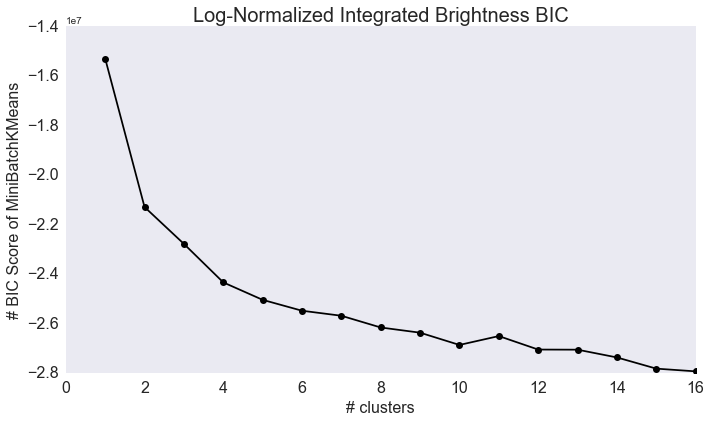

In [10]:
data = np.load('../../data/synapse_f0_features_log_normalized.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig = plt.figure(figsize=(10, 6))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("Log-Normalized Integrated Brightness BIC", fontsize=20)
plt.xlabel("# clusters", fontsize=16)
plt.ylabel("# BIC Score of MiniBatchKMeans", fontsize=16)
ax.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

print "For f0 features log transformed and normalized"

For f0 features Log Transform and Normalized Filtered out bottom 25%
For f0 features Log Transform and Normalized Filtered out bottom 50%
For f0 features Log Transform and Normalized Filtered out bottom 75%


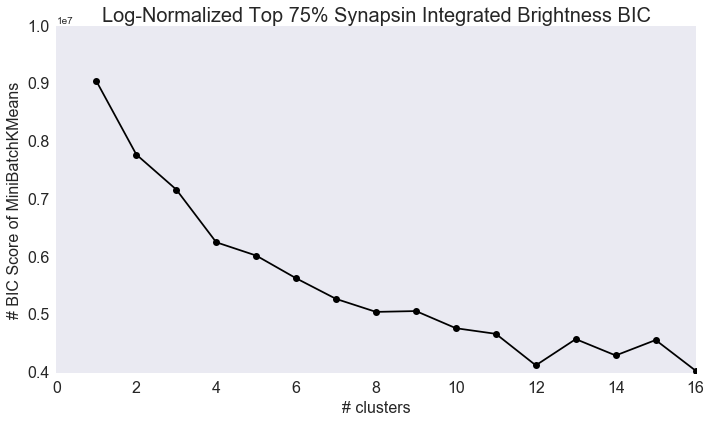

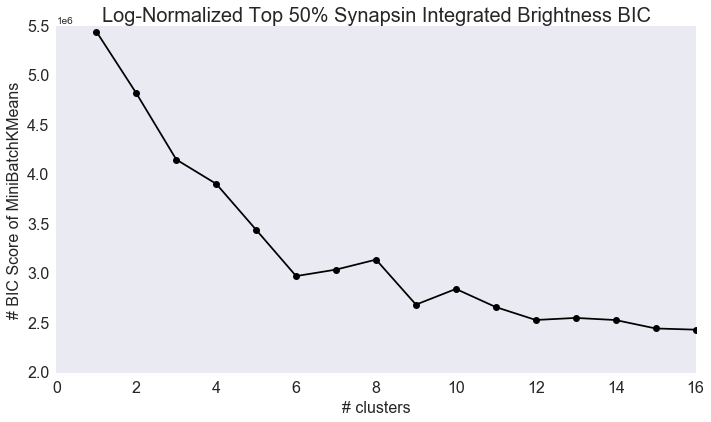

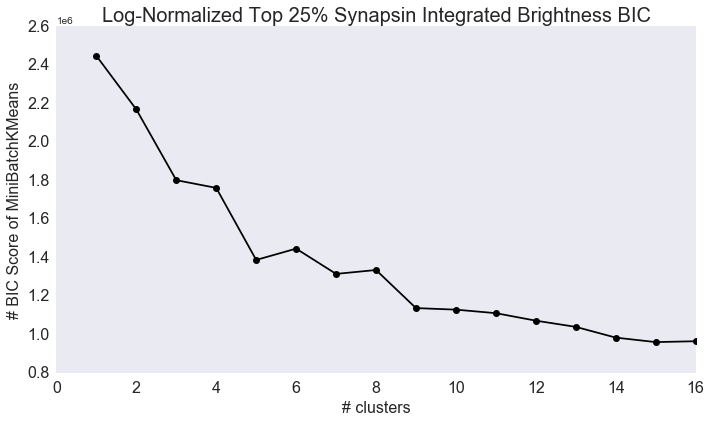

In [11]:
data = np.load('../../data/f0_features_log_normalized_bottom25.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run n times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig = plt.figure(figsize=(10, 6))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("Log-Normalized Top 75% Synapsin Integrated Brightness BIC", fontsize=20)
plt.xlabel("# clusters", fontsize=16)
plt.ylabel("# BIC Score of MiniBatchKMeans", fontsize=16)
ax.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

print "For f0 features Log Transform and Normalized Filtered out bottom 25%"


data = np.load('../../data/f0_features_log_normalized_bottom50.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run n times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig = plt.figure(figsize=(10, 6))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("Log-Normalized Top 50% Synapsin Integrated Brightness BIC", fontsize=20)
plt.xlabel("# clusters", fontsize=16)
plt.ylabel("# BIC Score of MiniBatchKMeans", fontsize=16)
ax.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

print "For f0 features Log Transform and Normalized Filtered out bottom 50%"

data = np.load('../../data/f0_features_log_normalized_bottom75.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run n times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig = plt.figure(figsize=(10, 6))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("Log-Normalized Top 25% Synapsin Integrated Brightness BIC", fontsize=20)
plt.xlabel("# clusters", fontsize=16)
plt.ylabel("# BIC Score of MiniBatchKMeans", fontsize=16)
ax.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

print "For f0 features Log Transform and Normalized Filtered out bottom 75%"

## Load in Data And Cluster And Evaluate
1. load in data
2. cluster using k-means 4, 5, 6
3. PCA into 2/3 dimensions and also make a Scree plot (up to n=6)
4. Compare cluster distributions of labels in 2/3 dimensions
5. compare the histogram distributions of excit/inhib values in each cluster

In [12]:
data = np.load('../../data/synapse_f0_features_log_normalized.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# set options and then cluster
num_clusters = 4
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(X)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

print "Clustered With MiniBatchKmeans using ", num_clusters, " clusters"

data has shape:  (1119299, 16)
Clustered With MiniBatchKmeans using  4  clusters


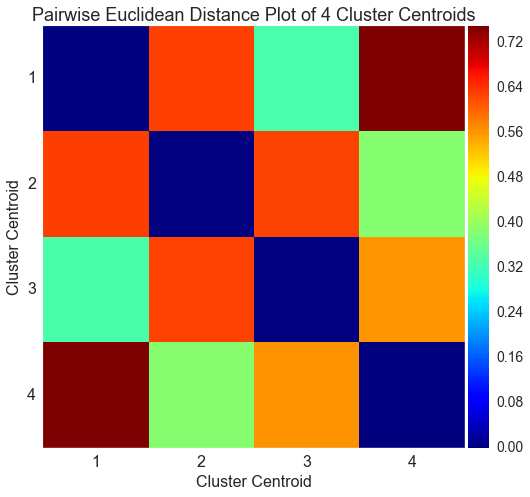

In [23]:
# compute distances between each centroid
distances = scipy.spatial.distance.pdist(k_means_cluster_centers)
distances = scipy.spatial.distance.squareform(distances)

labels = np.arange(1,5)
labels = [str(i) for i in labels]
numticks=4

# Plot the distances
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
im = plt.imshow(distances, cmap=plt.get_cmap('jet'), interpolation='none')
plt.title("Pairwise Euclidean Distance Plot of 4 Cluster Centroids", fontsize=18)
plt.yticks(np.arange(0.0, 4.0, 1.), labels,fontsize=16)
plt.xticks(np.arange(0.0, 4.0, 1.), labels,fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Cluster Centroid',fontsize=16)
plt.ylabel('Cluster Centroid',fontsize=16)
ax.grid(False)
vmin, vmax = plt.gci().get_clim()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=14)

In [30]:
# set options and then cluster
num_clusters = 16
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(X)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

print "Clustered With MiniBatchKmeans using ", num_clusters, " clusters"

Clustered With MiniBatchKmeans using  17  clusters


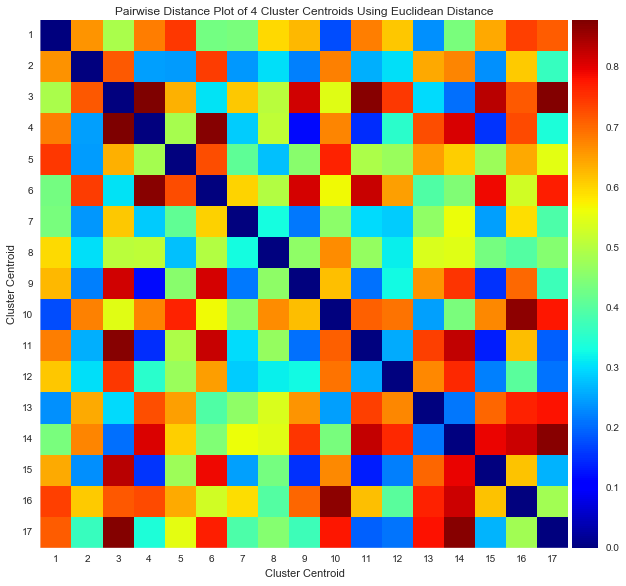

In [37]:
# compute distances between each centroid
distances = scipy.spatial.distance.pdist(k_means_cluster_centers)
distances = scipy.spatial.distance.squareform(distances)

labels = np.arange(1,18)
labels = [str(i) for i in labels]

# Plot the distances
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
im = plt.imshow(distances, cmap=plt.get_cmap('jet'), interpolation='none')
plt.title("Pairwise Distance Plot of 4 Cluster Centroids Using Euclidean Distance")
plt.yticks(np.arange(0.0, 17.0, 1.), labels)
plt.xticks(np.arange(0.0, 17.0, 1.), labels)
plt.xlabel('Cluster Centroid')
plt.ylabel('Cluster Centroid')
ax.grid(False)
vmin, vmax = plt.gci().get_clim()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Scree Plotting

data has shape:  (1119299, 24)
[ 0.41537043  0.19623631  0.1139861   0.10063133  0.0765407   0.02801826
  0.02013396  0.00953889  0.00852974  0.00820422  0.00668828  0.00497222
  0.00344453  0.00272281  0.00168754]
0.611606737481
0.996705330741


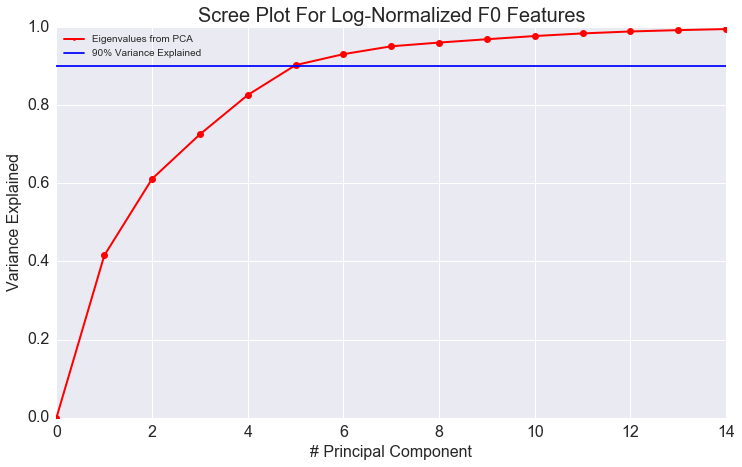

In [38]:
data = np.load('../../data/synapse_f0_features_log_normalized.npy')
X = data  # extract only the features
# X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# first PCA on entire dataset, then get the rows
num_components = 15
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)
sklearn_variance_explained = sklearn_pca.explained_variance_ratio_

# get the explained_ratio with number of components
sing_vals = np.arange(num_components)
eig_vals_ratio = [sum(sklearn_variance_explained[0:i]) for i in range(0,len(sklearn_variance_explained))]

# plot scree plot
fig = plt.figure(figsize=(12,7))
plt.plot(sing_vals, eig_vals_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot For Log-Normalized F0 Features', fontsize=20)
plt.xlabel('# Principal Component', fontsize=16)
plt.ylabel('Variance Explained', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(0.9, label='90% Variance')
leg = plt.legend(['Eigenvalues from PCA', '90% Variance Explained'], loc='best', borderpad=0.3, 
                 shadow=False, markerscale=0.4)

print sklearn_variance_explained
print sum(sklearn_variance_explained[0:2])
print sum(sklearn_variance_explained)

data has shape:  (839474, 22)
[ 0.44517019  0.15452244  0.14730356  0.05637773  0.04546224  0.03651752
  0.03005117  0.02255456  0.02124116  0.01360798  0.00841082  0.00660941
  0.00583938  0.00297452  0.00186935]
0.599692623901
0.746996187966


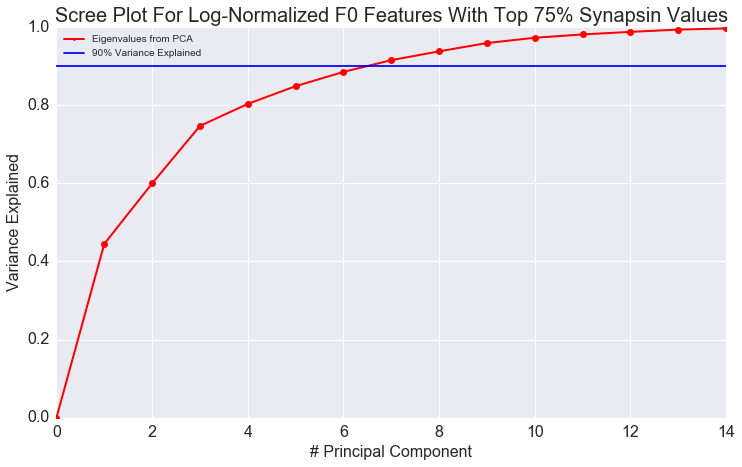

In [42]:
data = np.load('../../data/f0_features_log_normalized_bottom25.npy')
X = data  # extract only the features
# X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# first PCA on entire dataset, then get the rows
num_components = 15
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)
sklearn_variance_explained = sklearn_pca.explained_variance_ratio_

# get the explained_ratio with number of components
sing_vals = np.arange(num_components)
eig_vals_ratio = [sum(sklearn_variance_explained[0:i]) for i in range(0,len(sklearn_variance_explained))]

# plot scree plot
fig = plt.figure(figsize=(12,7))
plt.plot(sing_vals, eig_vals_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot For Log-Normalized F0 Features With Top 75% Synapsin Values', fontsize=20)
plt.xlabel('# Principal Component', fontsize=16)
plt.ylabel('Variance Explained', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(0.9, label='90% Variance')
leg = plt.legend(['Eigenvalues from PCA', '90% Variance Explained'], loc='best', borderpad=0.3, 
                 shadow=False, markerscale=0.4)

print sklearn_variance_explained
print sum(sklearn_variance_explained[0:2])
print sum(sklearn_variance_explained[0:3])

data has shape:  (559649, 22)
[ 0.40939468  0.17603253  0.14761577  0.05607543  0.04958256  0.03838892
  0.03163958  0.02616933  0.02262304  0.01423269  0.00862422  0.0070381
  0.00605515  0.00306461  0.0019096 ]
0.585427214336
0.733042985393


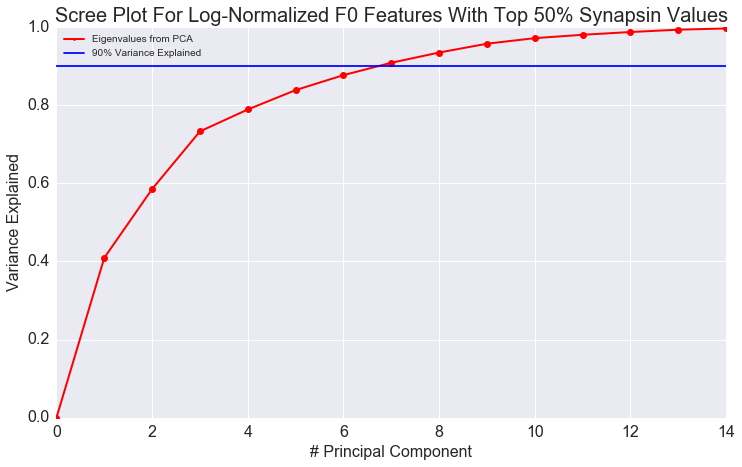

In [43]:
data = np.load('../../data/f0_features_log_normalized_bottom50.npy')
X = data  # extract only the features
# X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# first PCA on entire dataset, then get the rows
num_components = 15
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)
sklearn_variance_explained = sklearn_pca.explained_variance_ratio_

# get the explained_ratio with number of components
sing_vals = np.arange(num_components)
eig_vals_ratio = [sum(sklearn_variance_explained[0:i]) for i in range(0,len(sklearn_variance_explained))]

# plot scree plot
fig = plt.figure(figsize=(12,7))
plt.plot(sing_vals, eig_vals_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot For Log-Normalized F0 Features With Top 50% Synapsin Values', fontsize=20)
plt.xlabel('# Principal Component', fontsize=16)
plt.ylabel('Variance Explained', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(0.9, label='90% Variance')
leg = plt.legend(['Eigenvalues from PCA', '90% Variance Explained'], loc='best', borderpad=0.3, 
                 shadow=False, markerscale=0.4)

print sklearn_variance_explained
print sum(sklearn_variance_explained[0:2])
print sum(sklearn_variance_explained[0:3])

data has shape:  (279825, 22)
[ 0.38107539  0.1985457   0.14287292  0.05851739  0.05171232  0.04162924
  0.03093492  0.03030217  0.02230366  0.01381163  0.00851074  0.0076896
  0.00555956  0.00306231  0.00191105]
0.57962108518
0.72249400097


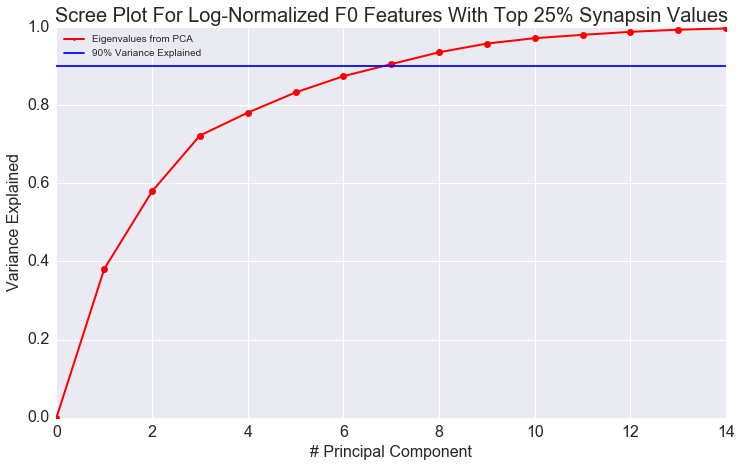

In [44]:
data = np.load('../../data/f0_features_log_normalized_bottom75.npy')
X = data  # extract only the features
# X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# first PCA on entire dataset, then get the rows
num_components = 15
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)
sklearn_variance_explained = sklearn_pca.explained_variance_ratio_

# get the explained_ratio with number of components
sing_vals = np.arange(num_components)
eig_vals_ratio = [sum(sklearn_variance_explained[0:i]) for i in range(0,len(sklearn_variance_explained))]

# plot scree plot
fig = plt.figure(figsize=(12,7))
plt.plot(sing_vals, eig_vals_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot For Log-Normalized F0 Features With Top 25% Synapsin Values', fontsize=20)
plt.xlabel('# Principal Component', fontsize=16)
plt.ylabel('Variance Explained', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(0.9, label='90% Variance')
leg = plt.legend(['Eigenvalues from PCA', '90% Variance Explained'], loc='best', borderpad=0.3, 
                 shadow=False, markerscale=0.4)

print sklearn_variance_explained
print sum(sklearn_variance_explained[0:2])
print sum(sklearn_variance_explained[0:3])

### Using PCA To Reduce Dimensionality
With PCA to reduce the dimensions down to 2 for each "synapse", it can capture ~70% of the data variance. 

Keeping that in mind while we analyze the cluster distributions With k=2, 4, 5, 6

number of components:  5
number of clusters:  2
For f0 features log transformed


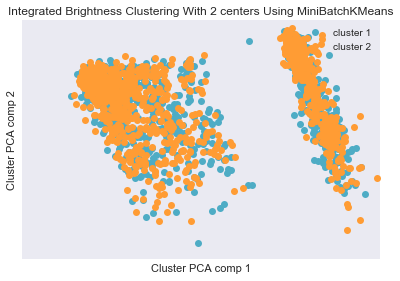

In [18]:
### First kmeans, then pca, then plot
data = np.load('../../data/synapse_f0_features_log_normalized.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# set options and then cluster
num_clusters = 2
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(X)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

print "Clustered With MiniBatchKmeans using ", num_clusters, " clusters"

print "number of components: ", num_components
print "number of clusters: ", num_clusters

## PCA
num_components = 5
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)

colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'black']

colori = []
colorj = []
labi = []
lab = []
for k, col in zip(range(num_clusters), colors):
    lab.append('cluster '+ str(k+1))
    
    my_members = k_means_labels == k # get indices of this current cluster membership
    cluster_center = k_means_cluster_centers[k] # get current cluster center
    
    rand_subset = np.random.choice(range(len(sklearn_transf[my_members,0])), size=1000, replace=False)
    ax.plot(sklearn_transf[rand_subset,0], sklearn_transf[rand_subset,1], 'wo', markerfacecolor=col, label=lab)

plt.figure(figsize=(20,15))
pca_plot_i = 1
for i in range(0, sklearn_transf.shape[1]):
    for j in range(0, sklearn_transf.shape[1]):
        plt.subplot(sklearn_transf.shape[1], sklearn_transf.shape[1], pca_plot_i)
        axes = plt.gca()
        if i==j:
            ymin, ymax = axes.get_ylim()
            xmin, xmax = axes.get_xlim()
            plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'PCA Component %d vs. %d'%(i+1, i+1), fontsize=20)
            plt.title('PCA Plots for Integrated Brightness')
            plt.grid(False)
        else:
            for k, col in zip(range(num_clusters), colors):
                lab = 'cluster '+ str(k+1)
                my_members = k_means_labels == k # get indices of this current cluster membership

                axes.plot(sklearn_transf[my_members,i], sklearn_transf[my_members,j], 'wo', markerfacecolor=col, label=lab)
            
            axes.set_title('PCA Plot for pc: ' + str(i) + ' vs. ' + str(j))
            axes.legend()

        pca_plot_i += 1 # increment index to plot subplot


##### PLOT #####
fig = plt.figure()
pca_plot_i = 1

ax = plt.gca()
for k, col in zip(range(num_clusters), colors):
    lab = 'cluster '+ str(k+1)
    
    my_members = k_means_labels == k # get indices of this current cluster membership
    cluster_center = k_means_cluster_centers[k] # get current cluster center
    
    rand_subset = np.random.choice(range(len(sklearn_transf[my_members,0])), size=1000, replace=False)
    ax.plot(sklearn_transf[rand_subset,0], sklearn_transf[rand_subset,1], 'wo', markerfacecolor=col, label=lab)

ax.grid(False)
ax.legend()
ax.set_xlabel('Cluster PCA comp 1')
ax.set_ylabel('Cluster PCA comp 2')
ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Using MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.tight_layout()

print "For f0 features log transformed"

## Now Do KMeans -> PCA -> Plot

number of components:  2
number of clusters:  6
For f0 features log normalized transformed


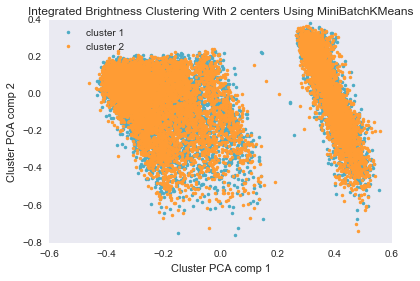

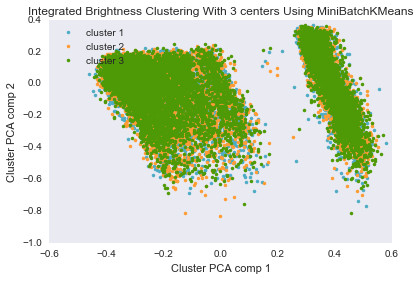

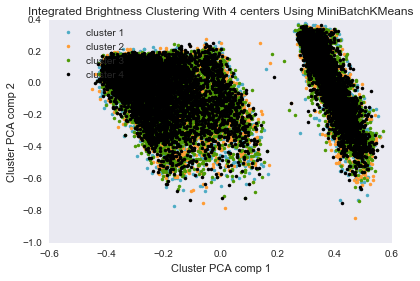

In [11]:
### First kmeans, then pca, then plot
print "number of components: ", num_components
print "number of clusters: ", num_clusters

num_clusters_list = [2, 3, 4]
for i in range(0, len(num_clusters_list)):
    ## Kmeans
    # set options and then cluster
    num_clusters = num_clusters_list[i]
    colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111']
    kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
    kmeans.fit(X)

    # extract the data after fitting
    k_means_labels = kmeans.labels_
    k_means_cluster_centers = kmeans.cluster_centers_
    k_means_labels_unique = np.unique(k_means_labels)

    ## PCA
    num_components = 2
    sklearn_pca = sklearnPCA(n_components=num_components)
    sklearn_transf = sklearn_pca.fit_transform(X)

    colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'black', 'green', 'blue']

    ##### PLOT #####
    fig = plt.figure()
    ax = plt.gca()
    for k, col in zip(range(num_clusters), colors):
        lab = 'cluster '+ str(k+1)

        my_members = k_means_labels == k # get indices of this current cluster membership
        cluster_center = k_means_cluster_centers[k] # get current cluster center

        rand_subset = np.random.choice(range(len(sklearn_transf[my_members,0])), size=10000, replace=False)
        ax.plot(sklearn_transf[rand_subset,0], sklearn_transf[rand_subset,1], 'w.', markerfacecolor=col, label=lab)

    ax.grid(False)
    ax.legend(loc='upper left')
    ax.set_xlabel('Cluster PCA comp 1')
    ax.set_ylabel('Cluster PCA comp 2')
    ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Using MiniBatchKMeans')
    # ax.set_xticks(())
    # ax.set_yticks(())
    plt.tight_layout()

print "For f0 features log normalized transformed"

## PCA -> KMeans -> Plot

number of components:  3
number of clusters:  2
PCA'ed shape:  (1119299, 2)
The shape of kmeans fit:  (3, 2)
For f0 features log transformed


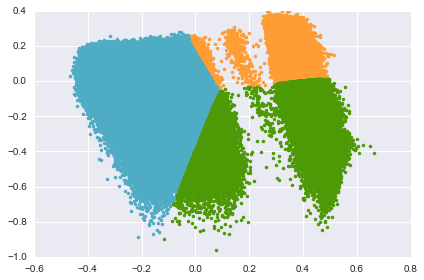

In [26]:
### First kmeans, then pca, then plot
print "number of components: ", num_components
print "number of clusters: ", num_clusters

## PCA
num_components = 2
sklearn_pca = sklearnPCA(n_components=num_components)
sklearn_transf = sklearn_pca.fit_transform(X)

print "PCA'ed shape: ", sklearn_transf.shape
## Kmeans
# set options and then cluster
num_clusters = 3
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit_predict(sklearn_transf)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
print "The shape of kmeans fit: ", k_means_cluster_centers.shape

colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'black']

##### PLOT #####
fig = plt.figure()
# ax = plt.gca()
for k, col in zip(range(num_clusters), colors):
    lab = 'cluster '+ str(k+1)
    
    my_members = k_means_labels == k # get indices of this current cluster membership
    cluster_center = k_means_cluster_centers[k] # get current cluster center
    
#     rand_subset = np.random.choice(range(len(sklearn_transf[my_members,0])), size=1000, replace=False)
    plt.plot(sklearn_transf[my_members,0], sklearn_transf[my_members,1], 'w.', markerfacecolor=col, label=lab)

ax.grid(False)
ax.legend(loc='upper left')
ax.set_xlabel('Cluster PCA comp 1')
ax.set_ylabel('Cluster PCA comp 2')
ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Using MiniBatchKMeans')
# ax.set_xticks(())
# ax.set_yticks(())
plt.tight_layout()

print "For f0 features log transformed"

### Cluster and Then Show Histograms of Each Protein's Expression

/Users/adam2392/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/adam2392/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


data has shape:  (1119299, 24)


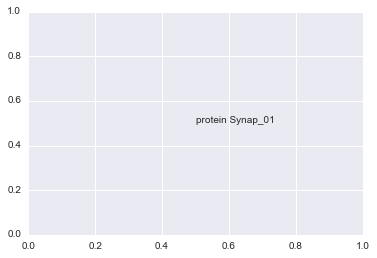

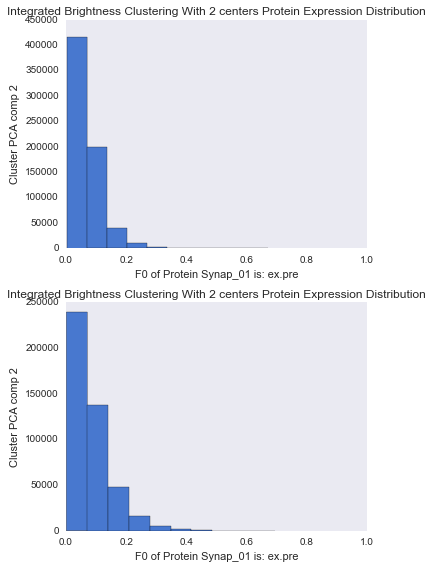

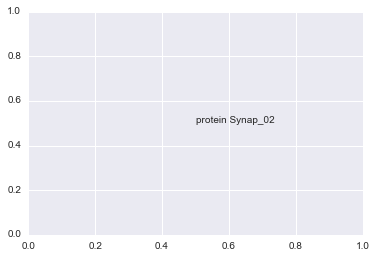

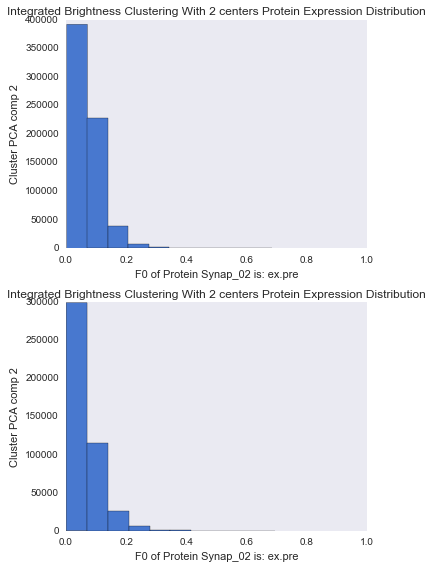

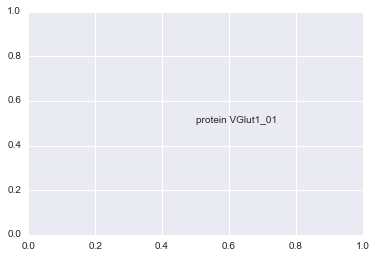

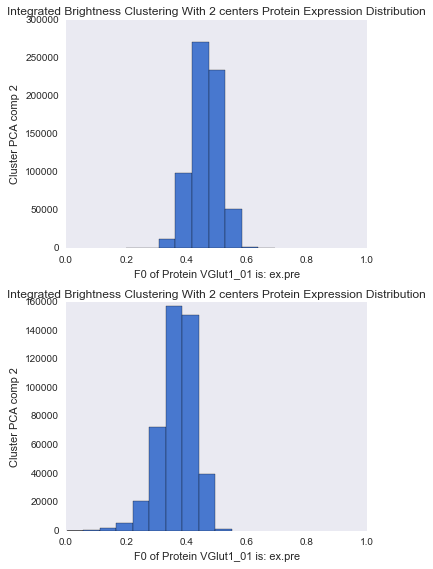

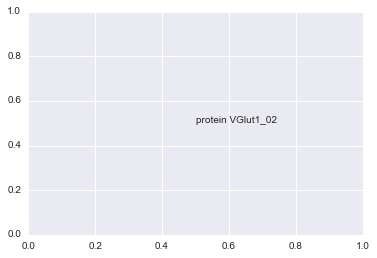

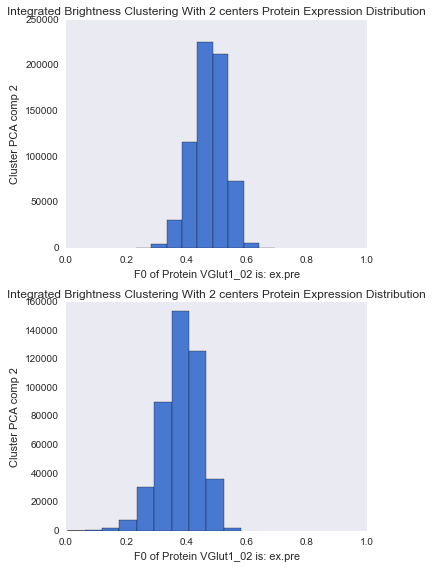

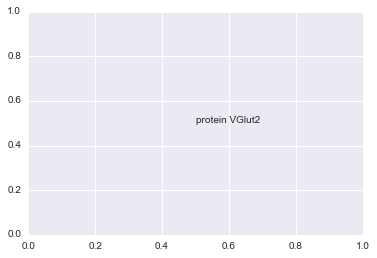

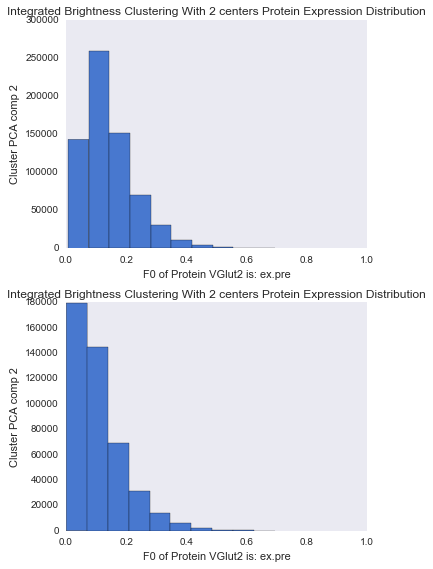

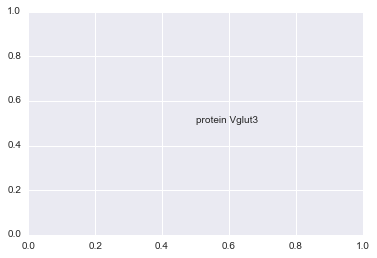

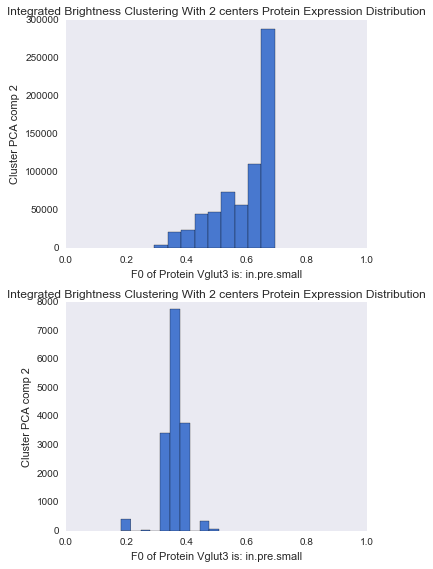

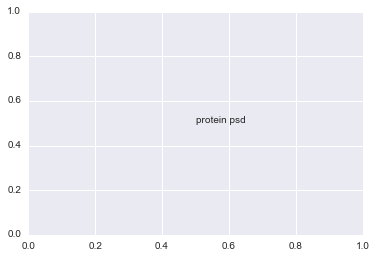

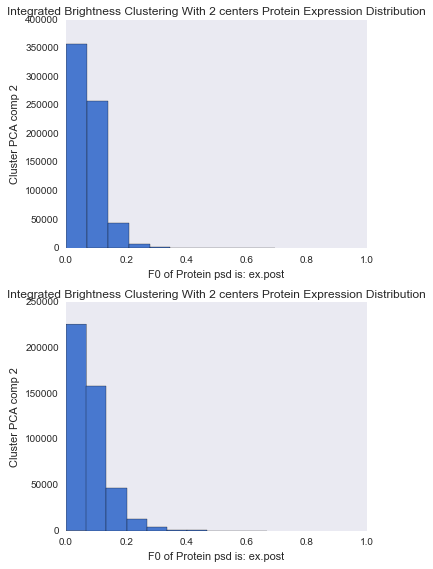

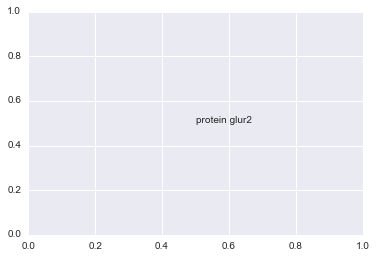

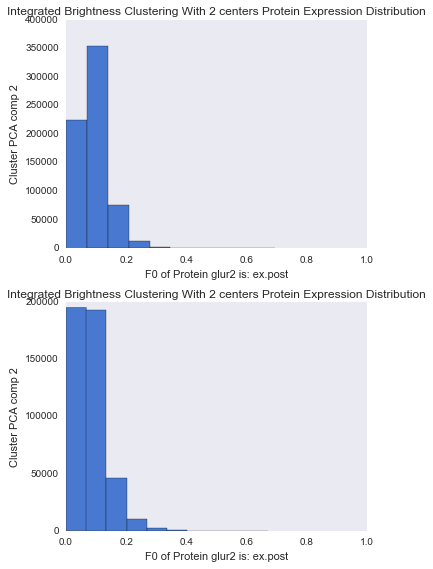

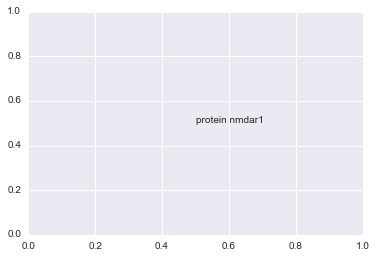

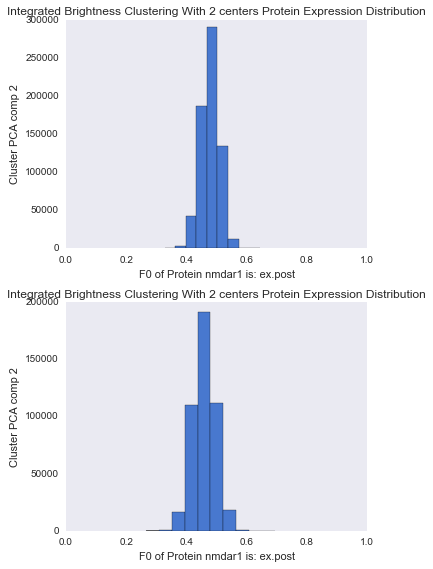

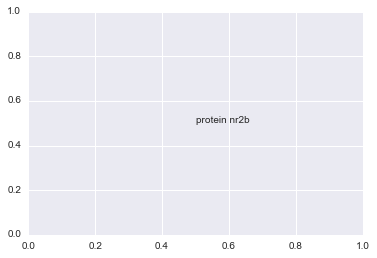

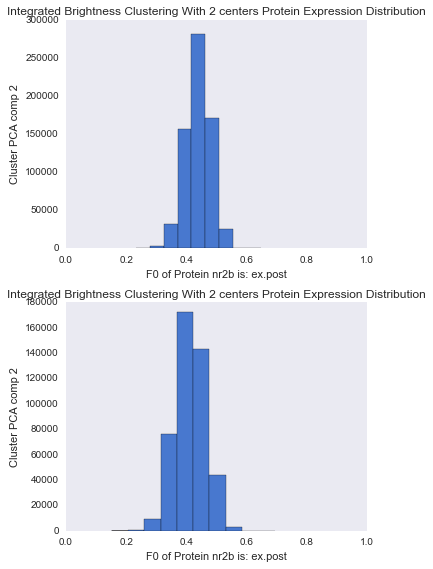

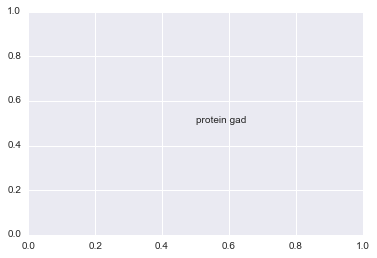

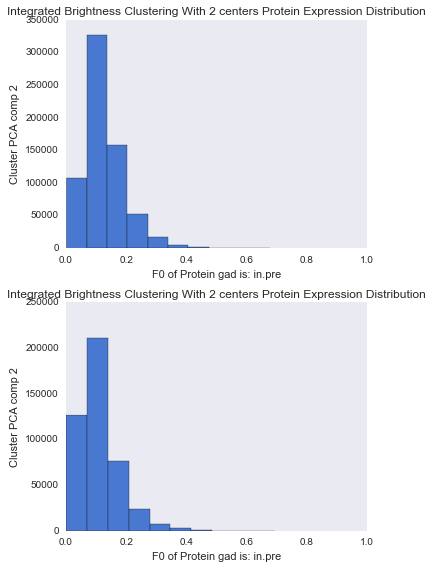

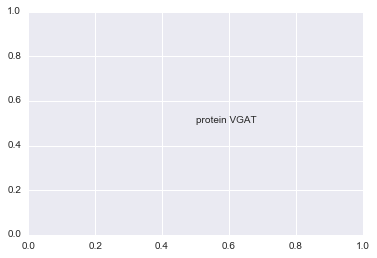

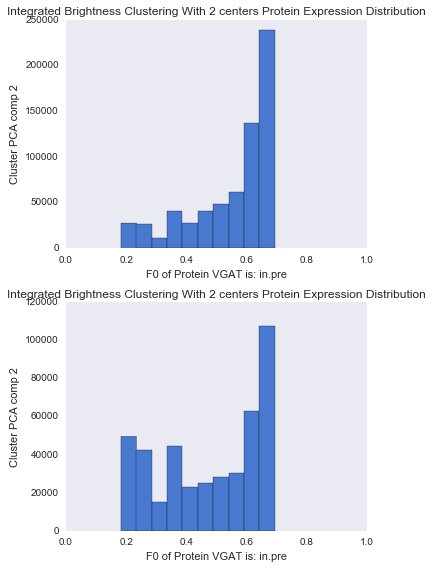

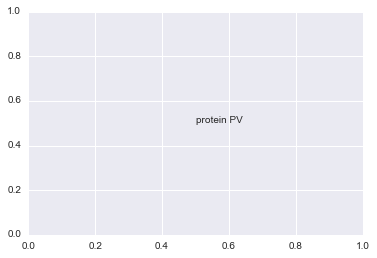

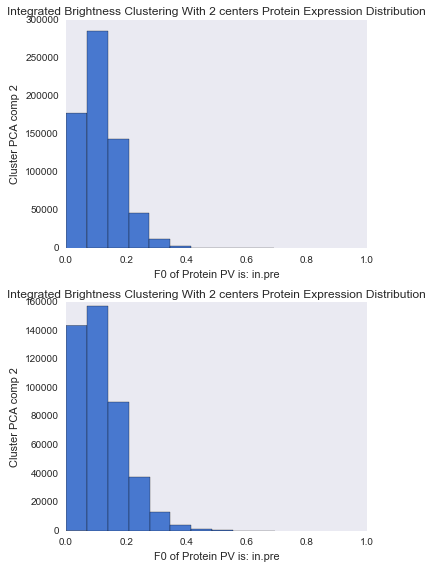

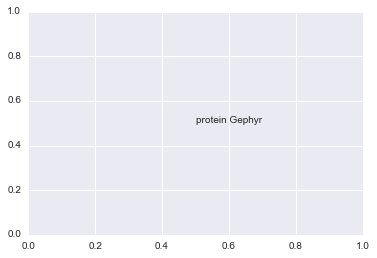

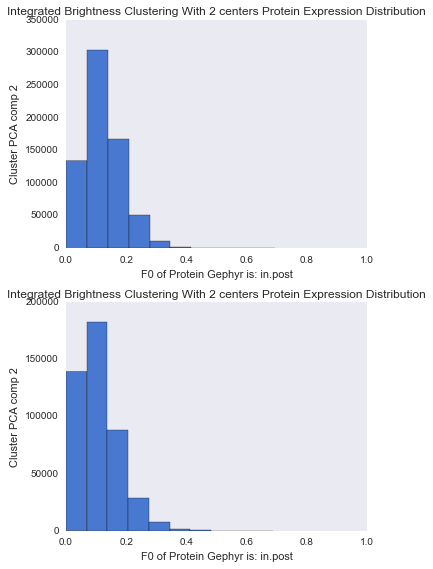

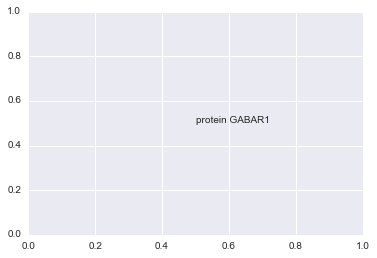

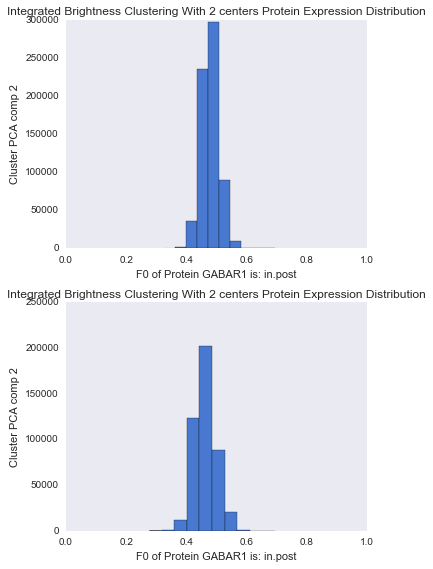

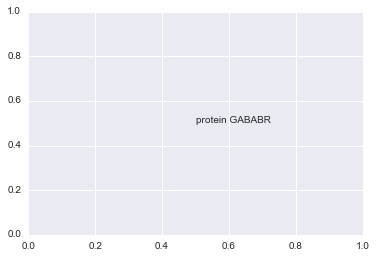

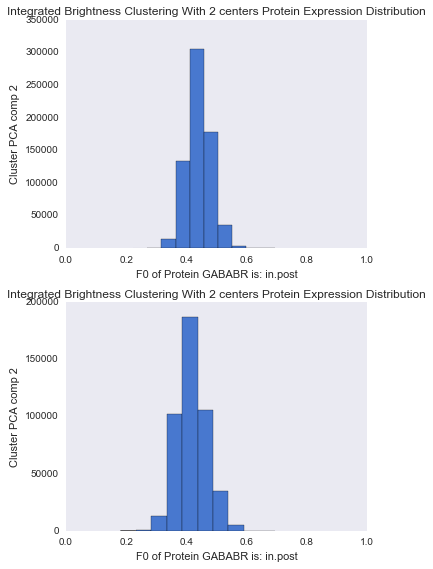

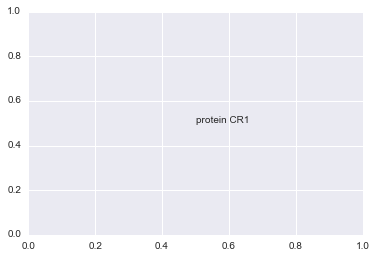

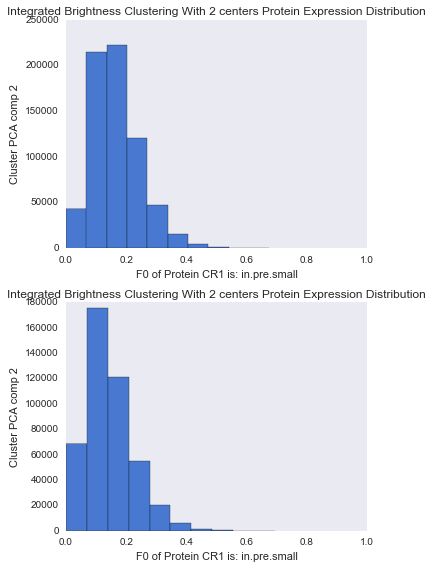

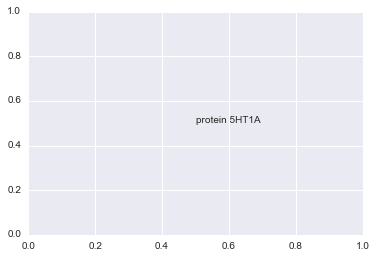

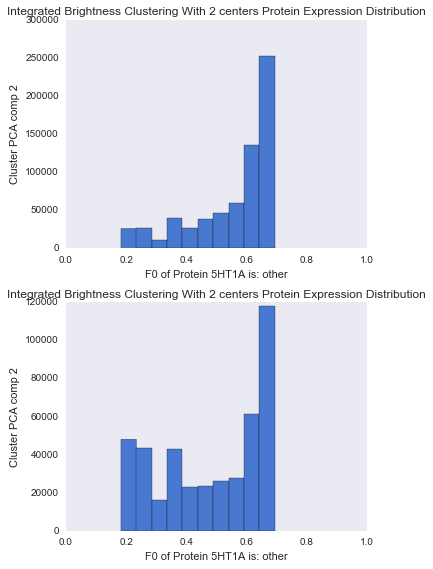

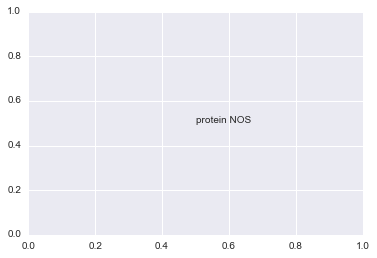

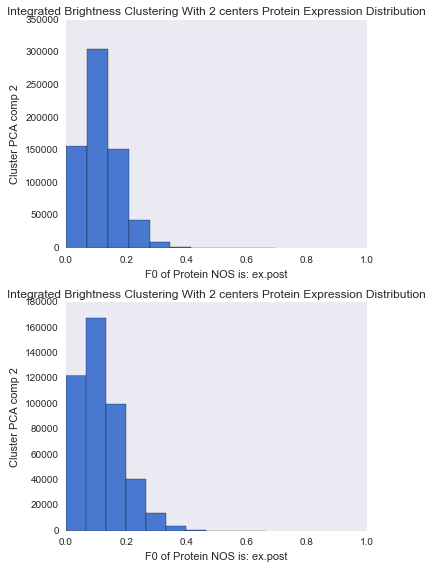

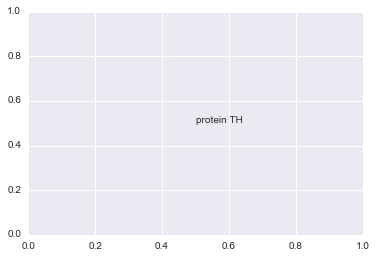

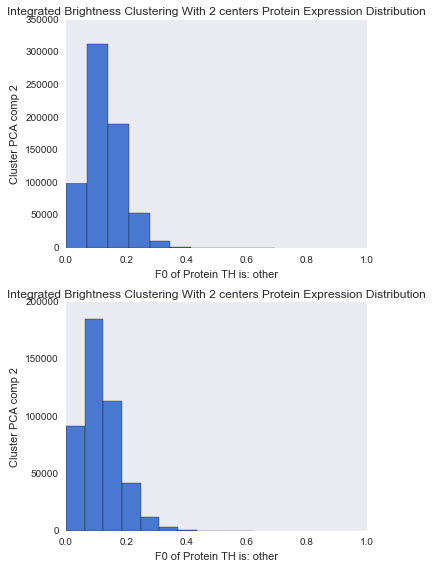

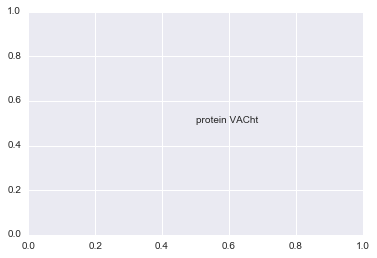

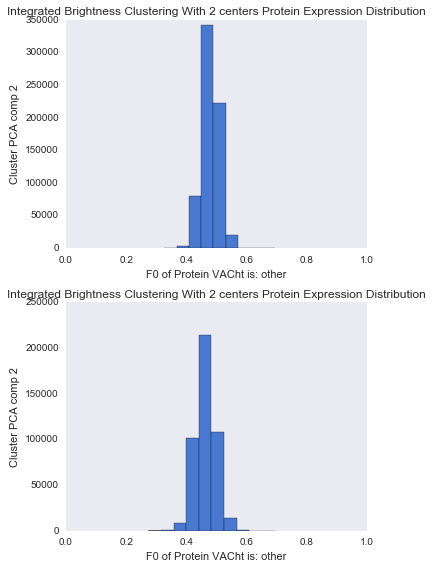

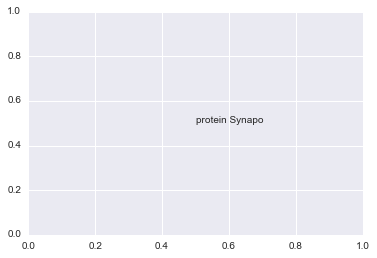

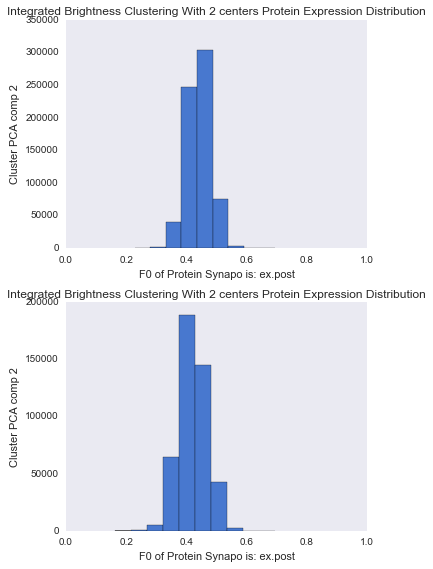

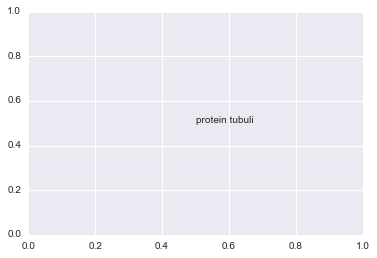

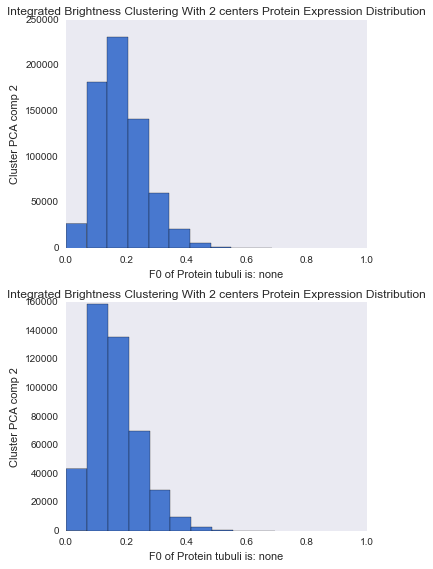

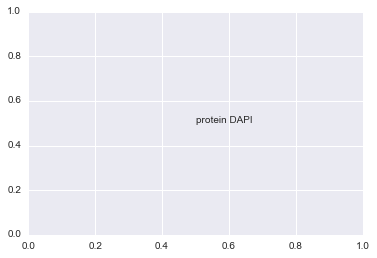

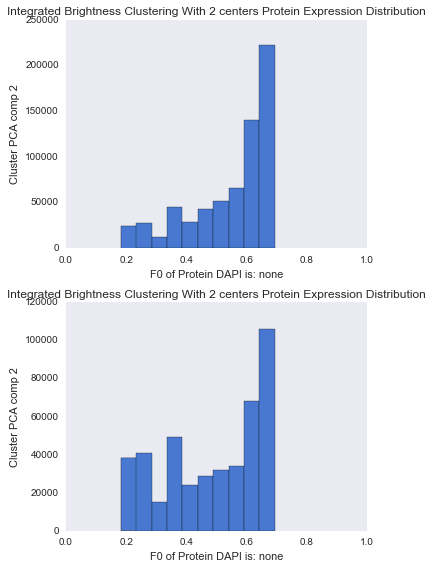

In [7]:
data = np.load('../../data/synapse_f0_features_log_normalized.npy')
X = data  # extract only the features
# X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# channel_inhib_excit = ['ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small', 
#                'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre', 
#                'in.pre','in.post','in.post','in.post']

# set options and then cluster
num_clusters = 2
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111', 'black', 'green', 'blue']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(X)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)


for i in range(0, len(channel)):#inhib_excit_indices)):
#     protein_to_plot = inhib_excit_indices[i]
    protein_to_plot = i
#     print protein_to_plot

    fig = plt.figure()
    plt.text(.5, .5, 'protein %s'%(channel[protein_to_plot]))

    
    ##### PLOT #####
    fig = plt.figure(figsize=(6,8))
    for k, col in zip(range(num_clusters), colors):
        ax = fig.add_subplot(num_clusters, 1, k+1)

    #     lab = 'cluster '+ str(k+1) # label for this distribution
        my_members = k_means_labels == k # get indices of this current cluster membership
        data = X[my_members,protein_to_plot]
        
        ## line to get rid of data with expression 0?
        data = data[data!=0]
        
        binwidth = 0.5
        ax.hist(data)
        ax.grid(False)
        ax.legend(loc='upper left')
        ax.set_xlabel('F0 of Protein ' + channel[protein_to_plot] + ' is: ' + channeltype[i])
        ax.set_ylabel('Cluster PCA comp 2')
        ax.set_xlim([0, 1.0])
        ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Protein Expression Distribution')
        plt.tight_layout()

## Dicsussion F0

Vglut3 separates visually for F0?

data has shape:  (1119299, 24)


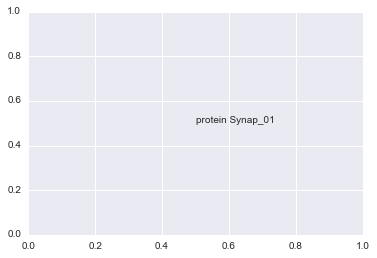

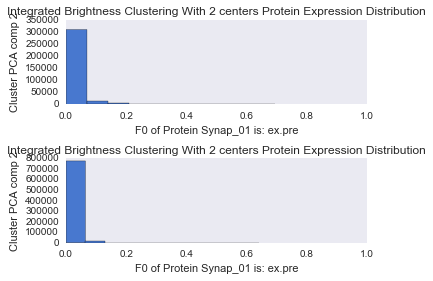

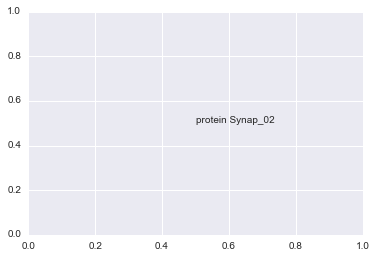

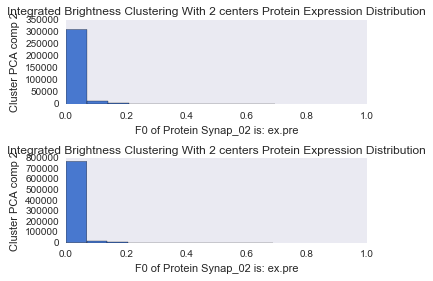

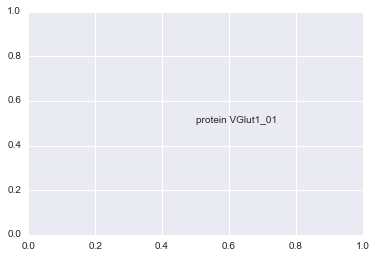

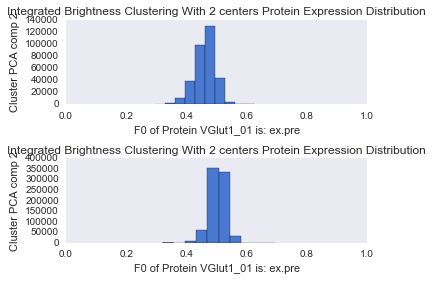

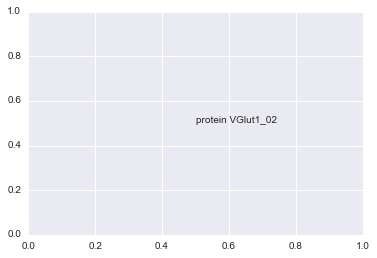

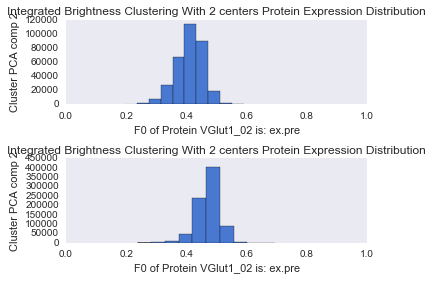

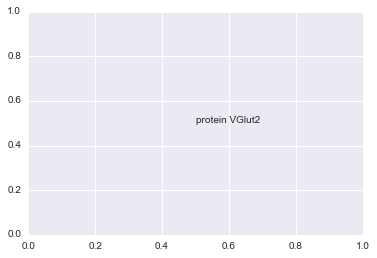

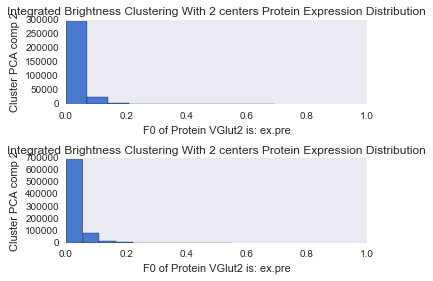

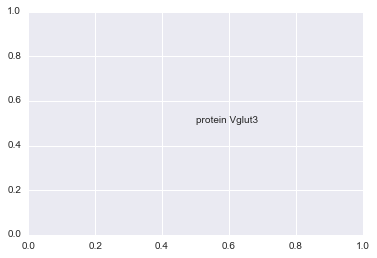

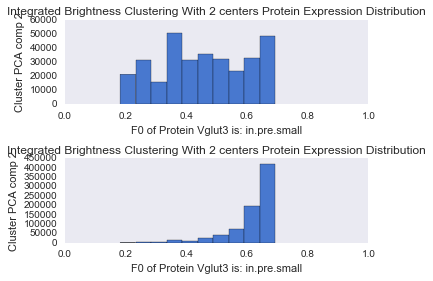

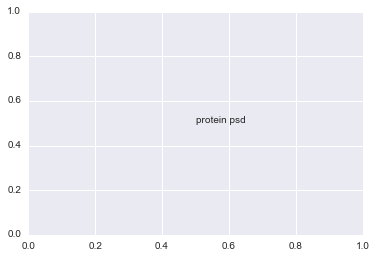

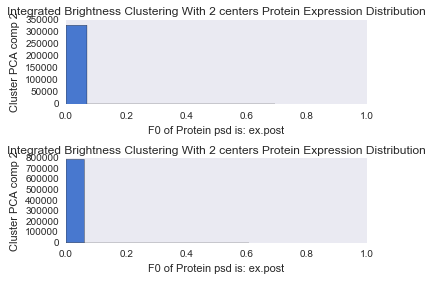

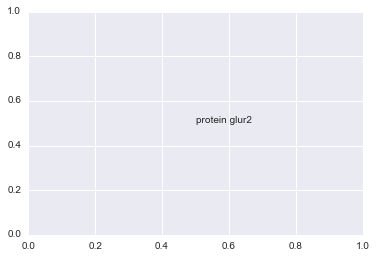

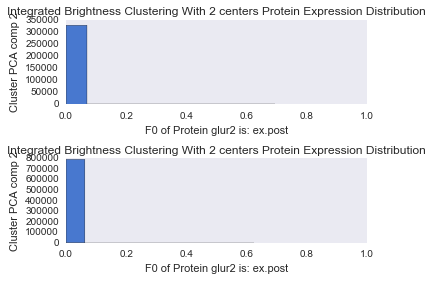

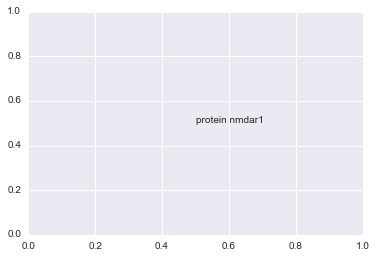

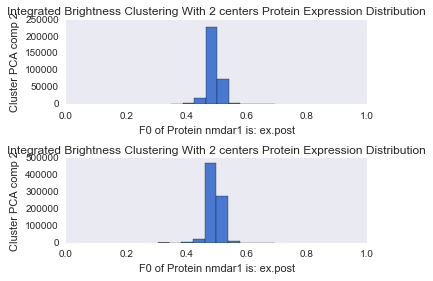

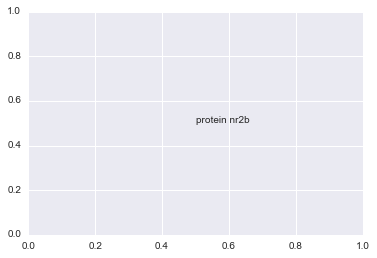

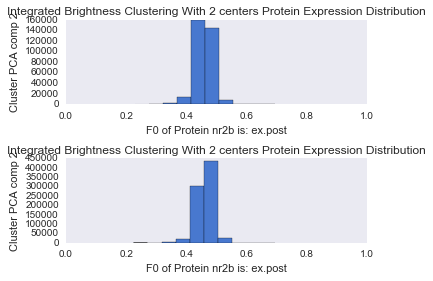

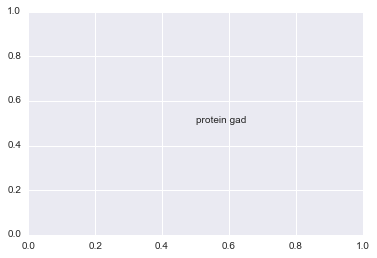

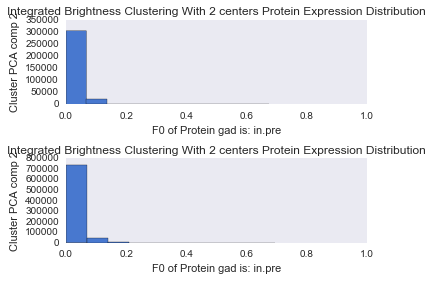

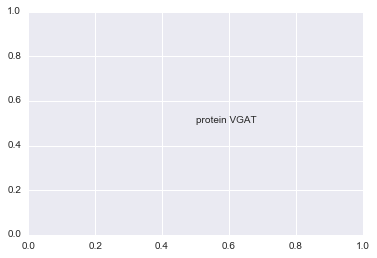

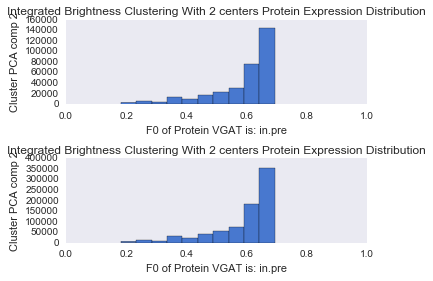

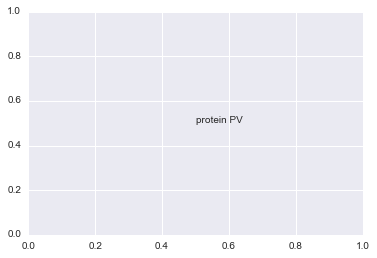

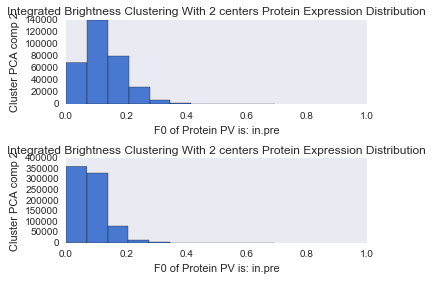

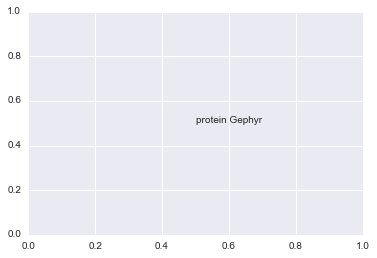

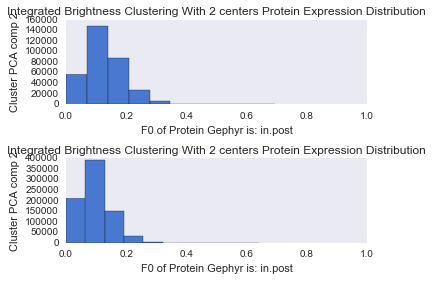

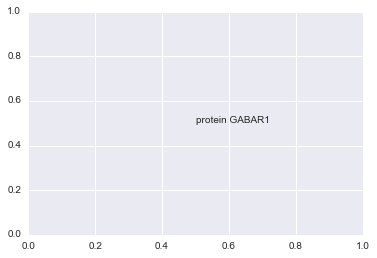

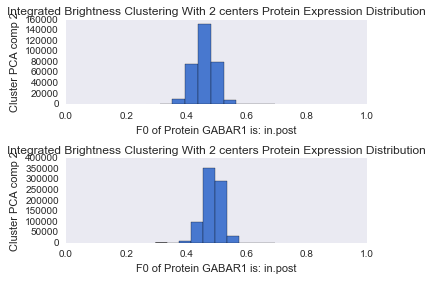

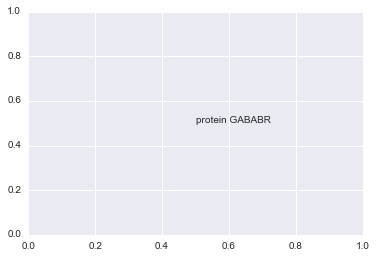

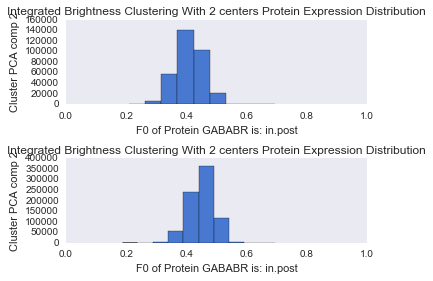

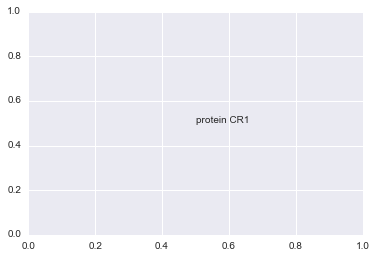

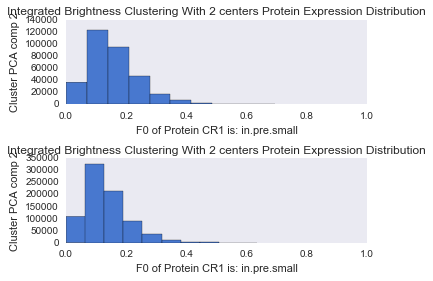

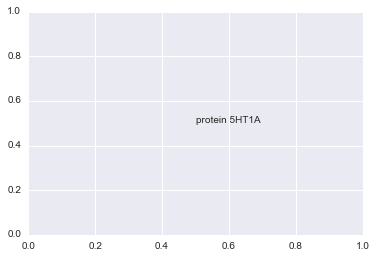

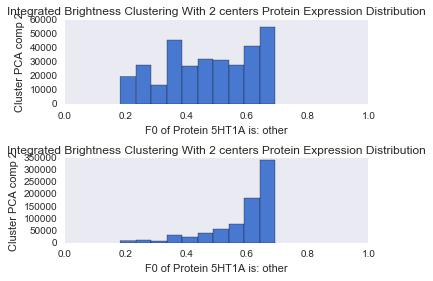

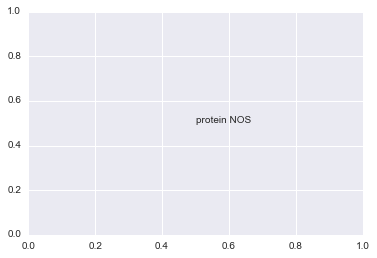

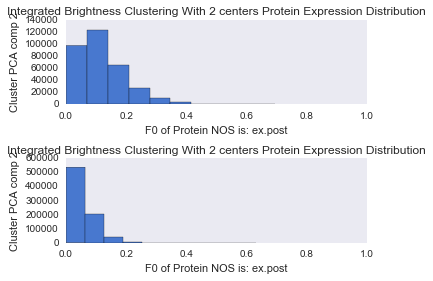

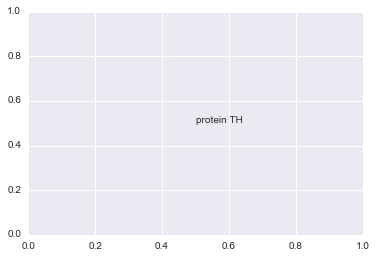

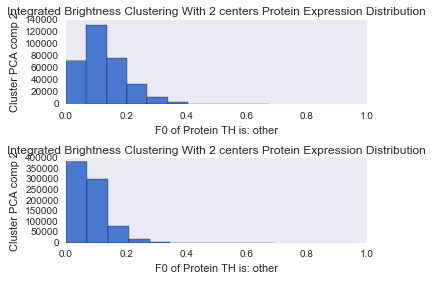

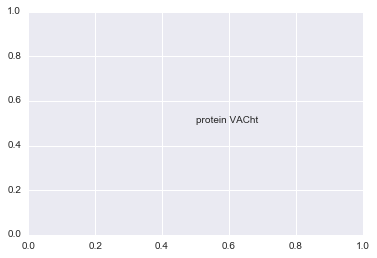

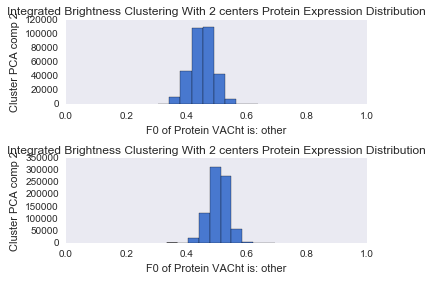

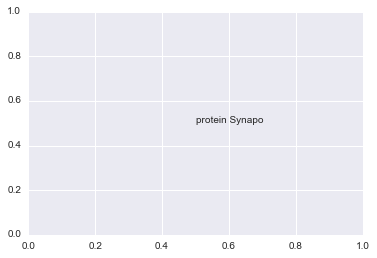

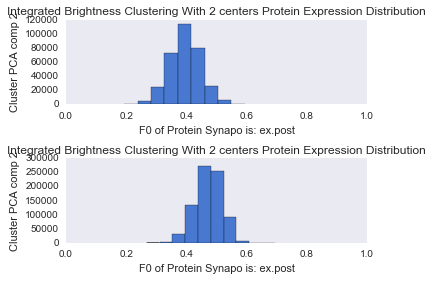

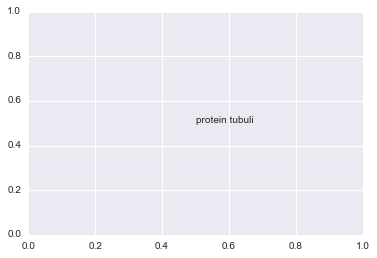

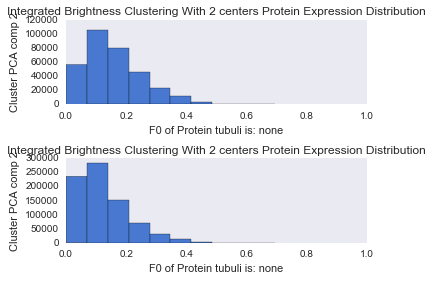

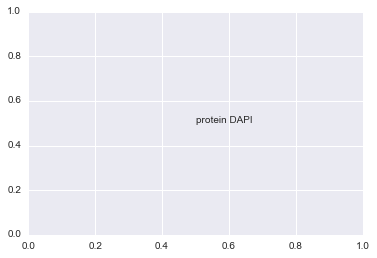

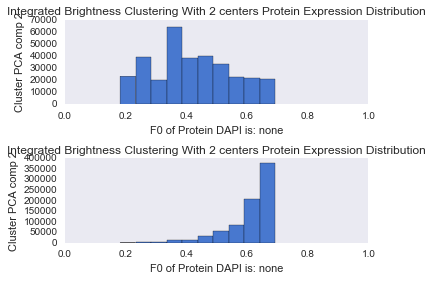

In [63]:
data = np.load('../../data/synapse_f1_features_log_normalized.npy')
X = data  # extract only the features
# X = X[:,inhib_excit_indices]
print 'data has shape: ', X.shape

# channel_inhib_excit = ['ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small', 
#                'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre', 
#                'in.pre','in.post','in.post','in.post']

# set options and then cluster
num_clusters = 2
colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#11111', 'black', 'green', 'blue']
kmeans = cluster.MiniBatchKMeans(n_clusters = num_clusters, init="k-means++")
kmeans.fit(X)

# extract the data after fitting
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)


for i in range(0, len(channel)):#inhib_excit_indices)):
#     protein_to_plot = inhib_excit_indices[i]
    protein_to_plot = i
#     print protein_to_plot

    fig = plt.figure()
    plt.text(.5, .5, 'protein %s'%(channel[protein_to_plot]))

    
    ##### PLOT #####
    fig = plt.figure()
    for k, col in zip(range(num_clusters), colors):
        ax = fig.add_subplot(num_clusters, 1, k+1)

    #     lab = 'cluster '+ str(k+1) # label for this distribution
        my_members = k_means_labels == k # get indices of this current cluster membership
        data = X[my_members,protein_to_plot]
        
        ## line to get rid of data with expression 0?
        data = data[data!=0]
        
        binwidth = 0.5
        ax.hist(data)
        ax.grid(False)
        ax.legend(loc='upper left')
        ax.set_xlabel('F0 of Protein ' + channel[protein_to_plot] + ' is: ' + channeltype[i])
        ax.set_ylabel('Cluster PCA comp 2')
        ax.set_xlim([0, 1.0])
        ax.set_title('Integrated Brightness Clustering With ' + str(num_clusters) + ' centers Protein Expression Distribution')
        plt.tight_layout()

## F1 Discussion
5HT1A and DAPI visually separate with Vglut3